<a href="https://colab.research.google.com/github/JQmiracle/BA_865_Final_Project/blob/main/Sally_220226_simple_models_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libararies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
df = pd.read_pickle('/content/task1_data.pkl')
df.rename(columns={'Facts': 'facts'}, inplace=True)
df.drop(columns=['index'], inplace=True)
df.reset_index(inplace=True)

print(f'There are {len(df)} cases.')

There are 3464 cases.


In [ ]:
# Create a mirrored case for each case, where the parties are swapped to prevent favoring first_party
df_list = df.values.tolist()
result = []
for row in df_list:
    result.append(row[1:])
    mirrored_row = row.copy()
    #  first_party is at index=4, second=5, winner_index=7
    mirrored_row[4] = row[5]
    mirrored_row[5] = row[4]
    mirrored_row[7] = 1-mirrored_row[7]
    result.append(mirrored_row[1:])
df2 = pd.DataFrame(result)
df2.rename(columns={
    0: 'ID',
    1: 'name',
    2: 'href',
    3: 'first_party',
    4: 'second_party',
    5: 'winning_party',
    6: 'winner_index',
    7: 'facts',
}, inplace=True)
df = df2
df.reset_index(inplace=True)

In [ ]:
avg_char = df['facts'].apply(lambda x: len(str(x))).mean()
print(f'Average facts character length: {avg_char:.0f}')

avg_word = df['facts'].apply(lambda x: len(str(x).split())).mean()
print(f'Average facts word length: {avg_word:.0f}')

del avg_char, avg_word

Average facts character length: 1179
Average facts word length: 189


In [ ]:
df.head(3)

,index,ID,name,href,first_party,second_party,winning_party,winner_index,facts
0,0,50606,Roe v. Wade,https://api.oyez.org/cases/1971/70-18,Jane Roe,Henry Wade,Jane Roe,0,"In 1970, Jane Roe (a fictional name used in co..."
1,1,50606,Roe v. Wade,https://api.oyez.org/cases/1971/70-18,Henry Wade,Jane Roe,Jane Roe,1,"In 1970, Jane Roe (a fictional name used in co..."
2,2,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,"Peter Stanley, Sr.",Illinois,Stanley,0,Joan Stanley had three children with Peter Sta...


# Data Preprocessing - NLP

In [ ]:
# # Perform an 80-20 split for training and testing data
X_train_party1_text, X_test_party1_text, \
X_train_party2_text, X_test_party2_text, \
X_train_facts_text, X_test_facts_text, \
y_train, y_test = train_test_split(
    df['first_party'],
    df['second_party'],
    df['facts'],
    df['winner_index'],
    test_size=0.2,
    stratify=df['winner_index'],
    random_state=865
)

In [ ]:
# TF-IDF Feature Extraction
vectorizer = TfidfVectorizer()
X_train_facts = vectorizer.fit_transform(X_train_facts_text)
X_test_facts = vectorizer.transform(X_test_facts_text)
X_train_party1 = vectorizer.transform(X_train_party1_text)
X_test_party1 = vectorizer.transform(X_test_party1_text)
X_train_party2 = vectorizer.transform(X_train_party2_text)
X_test_party2 = vectorizer.transform(X_test_party2_text)

X_train = np.concatenate([X_train_party1.todense(), X_train_party2.todense(), X_train_facts.todense()], axis=1)
X_test = np.concatenate([X_test_party1.todense(), X_test_party2.todense(), X_test_facts.todense()], axis=1)

del X_train_facts, X_train_party1, X_train_party2
del X_test_facts, X_test_party1, X_test_party2

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5542, 51042) (5542,) (1386, 51042) (1386,)


# Baseline Model

In [ ]:
# import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
base_model = keras.Sequential([
      layers.Dense(200, activation="relu", kernel_regularizer="l2"),
      layers.Dense(200, activation="tanh"),
      layers.Dense(1, activation="sigmoid"),     
    ])
base_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
base_history = base_model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_test, y_test))

Epoch 1/20
11/11 [==============================] - 9s 705ms/step - loss: 1.3424 - accuracy: 0.5438 - val_loss: 0.7196 - val_accuracy: 0.5657
Epoch 2/20
11/11 [==============================] - 7s 638ms/step - loss: 0.7116 - accuracy: 0.6193 - val_loss: 0.7399 - val_accuracy: 0.5815
Epoch 3/20
11/11 [==============================] - 7s 657ms/step - loss: 0.6948 - accuracy: 0.6723 - val_loss: 0.7412 - val_accuracy: 0.5851
Epoch 4/20
11/11 [==============================] - 7s 617ms/step - loss: 0.6700 - accuracy: 0.7099 - val_loss: 0.7695 - val_accuracy: 0.5815
Epoch 5/20
11/11 [==============================] - 7s 630ms/step - loss: 0.6441 - accuracy: 0.7398 - val_loss: 0.7770 - val_accuracy: 0.6053
Epoch 6/20
11/11 [==============================] - 7s 668ms/step - loss: 0.6200 - accuracy: 0.7663 - val_loss: 0.7919 - val_accuracy: 0.6068
Epoch 7/20
11/11 [==============================] - 7s 614ms/step - loss: 0.5975 - accuracy: 0.7945 - val_loss: 0.8272 - val_accuracy: 0.6205
Epoch 

In [ ]:
loss_metrics = base_model.evaluate(X_test,y_test,verbose=1)

44/44 [==============================] - 2s 34ms/step - loss: 1.2013 - accuracy: 0.6623


In [ ]:
train_loss_base_history = base_history.history['loss']
val_loss_base_history = base_history.history['val_loss']

train_acc_base_history = base_history.history['accuracy']
val_acc_base_history = base_history.history['val_accuracy']

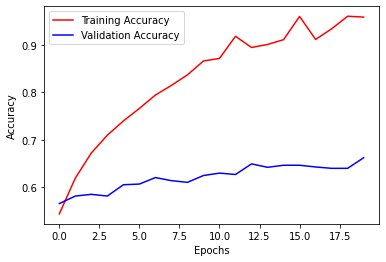

In [ ]:
# Plot validation performance. 
plt.plot(train_acc_base_history,c='r')
plt.plot(val_acc_base_history,c='b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.show()

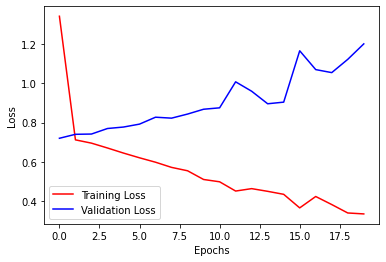

In [ ]:
plt.plot(train_loss_base_history,c="r")
plt.plot(val_loss_base_history,c='b')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training Loss','Validation Loss'])
plt.show()

# Simple Neural Network 1

Changed optimizer from rsmprop to adam

In [ ]:
model1 = keras.Sequential([
      layers.BatchNormalization(),
      layers.Dense(200, activation="relu", kernel_regularizer="l2"),
      layers.Dense(200, activation="tanh"),                                
      layers.Dense(1, activation="sigmoid"),     
    ])
model1.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
history1 = model1.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_test, y_test))

Epoch 1/20
11/11 [==============================] - 13s 1s/step - loss: 2.2072 - accuracy: 0.5063 - val_loss: 1.1118 - val_accuracy: 0.5000
Epoch 2/20
11/11 [==============================] - 11s 1s/step - loss: 0.8854 - accuracy: 0.8611 - val_loss: 1.0548 - val_accuracy: 0.5844
Epoch 3/20
11/11 [==============================] - 12s 1s/step - loss: 0.5232 - accuracy: 0.9181 - val_loss: 0.9751 - val_accuracy: 0.5000
Epoch 4/20
11/11 [==============================] - 12s 1s/step - loss: 0.3629 - accuracy: 0.9661 - val_loss: 0.8923 - val_accuracy: 0.6111
Epoch 5/20
11/11 [==============================] - 11s 1s/step - loss: 0.3023 - accuracy: 0.9720 - val_loss: 0.8600 - val_accuracy: 0.6097
Epoch 6/20
11/11 [==============================] - 12s 1s/step - loss: 0.3060 - accuracy: 0.9637 - val_loss: 0.8800 - val_accuracy: 0.6039
Epoch 7/20
11/11 [==============================] - 12s 1s/step - loss: 0.3372 - accuracy: 0.9681 - val_loss: 0.9217 - val_accuracy: 0.5260
Epoch 8/20
11/11 [==

In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 51042)            204168    
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 200)               10208600  
                                                                 
 dense_4 (Dense)             (None, 200)               40200     
                                                                 
 dense_5 (Dense)             (None, 1)                 201       
                                                                 
Total params: 10,453,169
Trainable params: 10,351,085
Non-trainable params: 102,084
_________________________________________________________________


In [ ]:
loss_metrics = model1.evaluate(X_test,y_test,verbose=1)

44/44 [==============================] - 2s 52ms/step - loss: 0.8229 - accuracy: 0.6530


In [ ]:
train_loss_history1 = history1.history['loss']
val_loss_history1 = history1.history['val_loss']

train_acc_history1 = history1.history['accuracy']
val_acc_history1 = history1.history['val_accuracy']

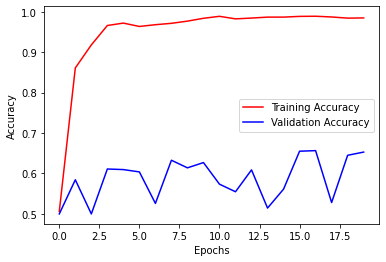

In [ ]:
# Plot validation performance. 
plt.plot(train_acc_history1,c='r')
plt.plot(val_acc_history1,c='b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.show()

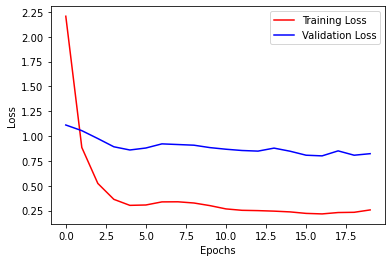

In [ ]:
plt.plot(train_loss_history1,c="r")
plt.plot(val_loss_history1,c='b')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training Loss','Validation Loss'])
plt.show()

# Simple model 2

To delay overfit, added another kernel regularizer and increased epochs

In [ ]:
model2 = keras.Sequential([
      layers.BatchNormalization(),
      layers.Dense(200, activation="relu", kernel_regularizer="l2"),
      layers.Dense(200, activation="tanh", kernel_regularizer="l2"),                                
      layers.Dense(1, activation="sigmoid"),     
    ])
model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
history2 = model2.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=(X_test, y_test))

Epoch 1/50
11/11 [==============================] - 13s 1s/step - loss: 3.9940 - accuracy: 0.5045 - val_loss: 2.6520 - val_accuracy: 0.5000
Epoch 2/50
11/11 [==============================] - 12s 1s/step - loss: 2.2472 - accuracy: 0.8565 - val_loss: 2.2427 - val_accuracy: 0.5859
Epoch 3/50
11/11 [==============================] - 13s 1s/step - loss: 1.6046 - accuracy: 0.9116 - val_loss: 1.8477 - val_accuracy: 0.5988
Epoch 4/50
11/11 [==============================] - 12s 1s/step - loss: 1.2072 - accuracy: 0.9592 - val_loss: 1.5999 - val_accuracy: 0.5476
Epoch 5/50
11/11 [==============================] - 13s 1s/step - loss: 0.9457 - accuracy: 0.9675 - val_loss: 1.3918 - val_accuracy: 0.6032
Epoch 6/50
11/11 [==============================] - 13s 1s/step - loss: 0.7811 - accuracy: 0.9677 - val_loss: 1.2776 - val_accuracy: 0.5245
Epoch 7/50
11/11 [==============================] - 12s 1s/step - loss: 0.6662 - accuracy: 0.9648 - val_loss: 1.1712 - val_accuracy: 0.5577
Epoch 8/50
11/11 [==

In [ ]:
loss_metrics = model2.evaluate(X_test,y_test,verbose=1)

44/44 [==============================] - 2s 52ms/step - loss: 0.9723 - accuracy: 0.6371


In [ ]:
train_loss_history2 = history2.history['loss']
val_loss_history2 = history2.history['val_loss']

train_acc_history2 = history2.history['accuracy']
val_acc_history2 = history2.history['val_accuracy']

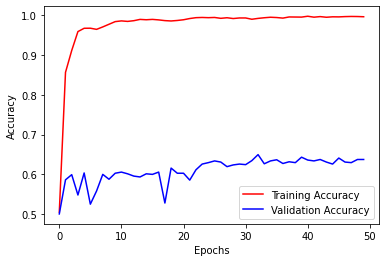

In [ ]:
# Plot validation performance. 
plt.plot(train_acc_history2,c='r')
plt.plot(val_acc_history2,c='b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.show()

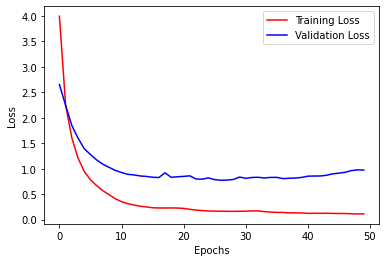

In [ ]:
plt.plot(train_loss_history2,c="r")
plt.plot(val_loss_history2,c='b')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training Loss','Validation Loss'])
plt.show()

# Simple Model 3

In [ ]:
model3 = keras.Sequential([
      layers.Dropout(0.1),
      layers.BatchNormalization(),
      layers.Dense(200, activation="relu", kernel_regularizer="l2"),
      layers.Dropout(0.2),
      layers.BatchNormalization(),      
      layers.Dense(200, activation="tanh", kernel_regularizer="l2"),                                
      layers.Dense(1, activation="sigmoid"),     
    ])
model3.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
history3 = model3.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=(X_test, y_test))

Epoch 1/50
11/11 [==============================] - 17s 1s/step - loss: 4.3222 - accuracy: 0.5051 - val_loss: 3.1946 - val_accuracy: 0.5000
Epoch 2/50
11/11 [==============================] - 14s 1s/step - loss: 2.9580 - accuracy: 0.7485 - val_loss: 2.9191 - val_accuracy: 0.5238
Epoch 3/50
11/11 [==============================] - 14s 1s/step - loss: 2.2799 - accuracy: 0.8984 - val_loss: 2.4847 - val_accuracy: 0.5505
Epoch 4/50
11/11 [==============================] - 13s 1s/step - loss: 1.7546 - accuracy: 0.9599 - val_loss: 2.1296 - val_accuracy: 0.5000
Epoch 5/50
11/11 [==============================] - 14s 1s/step - loss: 1.3945 - accuracy: 0.9691 - val_loss: 1.8429 - val_accuracy: 0.5058
Epoch 6/50
11/11 [==============================] - 14s 1s/step - loss: 1.1367 - accuracy: 0.9709 - val_loss: 1.6290 - val_accuracy: 0.5000
Epoch 7/50
11/11 [==============================] - 14s 1s/step - loss: 0.9594 - accuracy: 0.9697 - val_loss: 1.4782 - val_accuracy: 0.5014
Epoch 8/50
11/11 [==

In [ ]:
loss_metrics = model3.evaluate(X_test,y_test,verbose=1)

44/44 [==============================] - 2s 37ms/step - loss: 0.9594 - accuracy: 0.6631


In [ ]:
train_loss_history3 = history3.history['loss']
val_loss_history3 = history3.history['val_loss']

train_acc_history3 = history3.history['accuracy']
val_acc_history3 = history3.history['val_accuracy']

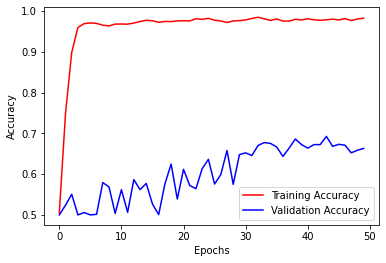

In [ ]:
# Plot validation performance. 
plt.plot(train_acc_history3,c='r')
plt.plot(val_acc_history3,c='b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.show()

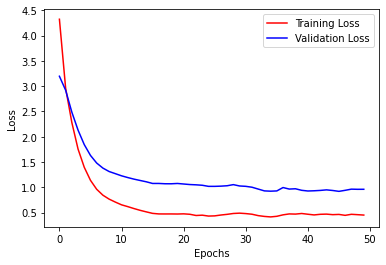

In [ ]:
plt.plot(train_loss_history3,c="r")
plt.plot(val_loss_history3,c='b')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training Loss','Validation Loss'])
plt.show()